In [1]:
import numpy as np
import matplotlib.pyplot as plt
import experiment
import interpret
import cosmology
import consensus
#import dill
import copy
import yaml

In [2]:
from sim_configuration import Configuration
class Results():
    def __init__(self):
        pass
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, d):
        self.__dict__ = d

In [5]:
histories = [{'cosmological_model_history':[], 'cosmological_paramter_history':[],'nuisance_parameter_history':[], 'systematics_parameter_history':[], 
    'cosmological_parameter_covariance_history':[]},
    {'cosmological_model_history':[], 'cosmological_paramter_history':[],'nuisance_parameter_history':[], 'systematics_parameter_history':[], 
        'cosmological_parameter_covariance_history':[]}]
for i in range(3):
    histories[0]['cosmological_model_history'].append(i)
histories

[{'cosmological_model_history': [0, 1, 2],
  'cosmological_paramter_history': [],
  'nuisance_parameter_history': [],
  'systematics_parameter_history': [],
  'cosmological_parameter_covariance_history': []},
 {'cosmological_model_history': [],
  'cosmological_paramter_history': [],
  'nuisance_parameter_history': [],
  'systematics_parameter_history': [],
  'cosmological_parameter_covariance_history': []}]

In [4]:
histories=[history,history]
histories[0]['cosmological_paramter_history'].append(4)
histories

[{'cosmological_model_history': [0, 1, 2],
  'cosmological_paramter_history': [4]},
 {'cosmological_model_history': [0, 1, 2],
  'cosmological_paramter_history': [4]}]

In [28]:
def plot_fits(filename,experiments,interpreters):
    # Plot the fits at each iteration
    colors = ['teal','orchid']
    fig,ax = plt.subplots(figsize=(7,7))
    for i in range(len(experiments)):
        datastr = r'Data {}, $\chi^2 = ${:.3}'.format(i,interpreters[i].chi2)
        ax.plot(experiments[i].times,experiments[i].observed_data_vector,label=datastr,marker='.',color=colors[i])
        ax.plot(interpreters[i].times,interpreters[i].best_fit_observed_model,label=f'Model {i} with Systematics',color=colors[i])
        ax.plot(interpreters[i].times,interpreters[i].best_fit_ideal_model,label=f'Model {i} w/out Systematics',linestyle='--',color=colors[i])
    ax.set_ylim(-1.2,1)
    ax.set_xlabel('time')
    ax.set_ylabel('position')
    ax.legend(loc='lower right',frameon=False)

In [6]:
# for this test in this notebook, break so we have something to plot
def run_consensus_compare(consensus_name, experiment_names, interpreter_names,
                          interpreter_cosmologies,
                          true_cosmology, experimental_parameters, noise_parameters,
                          consensus_kwargs,
                          max_iter=1000,
                          starting_systematics = [np.array(0.)], true_systematics=[np.array(0.0)]):
    '''
    loops over experiments, and fits models to it.
    compare paraemeters models via a tension tension_metric; look at goodnesses of fit amongst
    multiple avenues (...)
    then update the systematics or cosmology model
    '''
    number_of_experiments = len(experiment_names)
    truth = getattr(cosmology, true_cosmology)()
    true_parameters = truth.get_parameter_set()
    if (len(experiment_names) > 1) & len(true_systematics) == 1:
        true_systematics_parameters = [true_systematics]*number_of_experiments
    elif len(experiment_names) != len(true_systematics):
        raise Exception("Length of true systematics vector should be either equal to the number of experiments, or be a list containing a single true systematics vector.")
    else:
        true_systematics_parameters = true_systematics

    if (len(experiment_names) > 1) & len(starting_systematics) == 1:
        starting_systematics_parameters = [starting_systematics]*number_of_experiments
    elif len(experiment_names) != len(starting_systematics):
        raise Exception("Length of starting systematics vector should be either equal to the number of experiments, or be a list containing a single starting systematics vector.")
    else:
        starting_systematics_parameters = starting_systematics

    # previously:
#    n_systematics_parameters = [number_of_systematics for i in interpreter_names] # list of lengths
#    starting_systematics_parameters = [np.zeros(i) for i in n_systematics_parameters]
    systematics_parameters =  starting_systematics_parameters # why? (we overwrite starting_systematics_parameters below! re-initialize to zeros)

    # if we are setting starting_systematics to zero or grabbing from yaml, do we still need number_of_systematics or n_systematics_parameters ??

    assert number_of_experiments == len(interpreter_names), "Experiment_names and interpreter_names should be the same length."

    if True:
        print("Ok buddy relax")

    experiments = []
    interpreters = []
    this_cosmology = interpreter_cosmologies.pop()

    for i in range(number_of_experiments):
        experiments.append(getattr(experiment,experiment_names[i])(cosmology=truth,experimental_parameters=experimental_parameters[i],
                                                                   cosmology_parameters=true_parameters[:truth.n_cosmological],
                                                                   nuisance_parameters=true_parameters[truth.n_cosmological:],
                                                                   systematics_parameters=true_systematics_parameters[i],
                                                                   noise_parameters = noise_parameters[i],seed=110))
        # Make an interpreter for each experiment, initialized to default starting values.
        experiments[i].generate_data()
        interpreters.append(getattr(interpret,interpreter_names[i])(experiment=experiments[i],cosmology=this_cosmology,
                                                                    starting_systematics_parameters=starting_systematics_parameters[i],
                                                                    noise_parameters=noise_parameters[i]))
    # Run sequence.
    still_ok = True
    systematics_iter = np.zeros(number_of_experiments)
    converged = False
    # each interpreter fits a model (like different cosmic probes)
    # testing different consensus rules
    for iter in range(max_iter):
        print(f"------------------------------")
        print(f"Iteration {iter}:")
        print(f"Using cosmology: {this_cosmology.name}")
        # Fit the models.
        for interpreter in interpreters:
            interpreter.fit_model()
            if np.any(np.diag(interpreter.best_fit_cosmological_parameter_covariance) < 0):
                print(f"the fit didn't proceed, your errors are {np.diag(interpreter.best_fit_cosmological_parameter_covariance)}- you should probably check your data, soldier")
                still_ok = False
                # TODO: fail more gracefully when the fitter doesn't converge.
                break
            else:
                errors = np.sqrt(np.diag(interpreter.best_fit_cosmological_parameter_covariance))

            print(f"best-fit parameters: {interpreter.best_fit_cosmological_parameters}")
            print(f"best-fit parameter errors: {errors}")
            print(f"fit chi2: {interpreter.chi2}")
            print(f"fit chi2/dof: {interpreter.chi2/interpreter.measured_data_vector.size}")

        if still_ok == False: break

        plot_fits(filename=f"{consensus_name}_iter-{iter:03}.png",experiments = experiments,interpreters = interpreters)
        break
        
#        consensus_kwargs={"chi2_dof_threshold":1.25, "patience":10}
        this_consensus = getattr(consensus,consensus_name)(interpretations = interpreters, **consensus_kwargs)
        this_consensus.tension_metric()
        print(f"value of the tension parameter: {this_consensus.tm}")
        print(f"tension: {this_consensus.is_tension}")
        this_consensus.render_judgment(number_of_tries = np.max(systematics_iter)) #render judgment

        if np.max(systematics_iter) > this_consensus.patience:
            print(f"Got tired of further refining experiments after {this_consensus.patience} iterations. Changing the cosmology")
        if (not this_consensus.is_tension) and (np.sum(this_consensus.systematics_judgment) == 0):
            print('No tension, and everybody fits the data yay!')
            converged = True
            break
        if this_consensus.cosmology_judgment is True:
            print(f"Updating the cosmology")
            systematics_iter[:] = 0
            if len(interpreter_cosmologies) == 0:
                print('Ran out of cosmologies to try!')
                break
            this_cosmology = interpreter_cosmologies.pop()
            systematics_parameters = starting_systematics_parameters
            for i,interpreter in enumerate(interpreters):
                #starting_systematics_parameters = systematics_parameters[i] #[np.zeros(i) for i in n_systematics_parameters]
                interpreters[i] = getattr(interpret,interpreter_names[i])(experiment = experiments[i], cosmology=this_cosmology,
                                                                          starting_systematics_parameters = starting_systematics_parameters[i],
                                                                          noise_parameters = noise_parameters[i])
        else:
            if np.sum(this_consensus.systematics_judgment) > 0:
                systematics_iter[this_consensus.systematics_judgment] = systematics_iter[this_consensus.systematics_judgment]+1
                for i,this_judgment in enumerate(this_consensus.systematics_judgment):
                    if this_judgment:
                        print(f"Adding systematic error sophistication to interpreter {i}.")
                        systematics_parameters[i] = np.concatenate((systematics_parameters[i],np.zeros(1)))
                        interpreters[i] = getattr(interpret,interpreter_names[i])(experiment = experiments[i], cosmology=this_cosmology,
                                                                                  starting_systematics_parameters = systematics_parameters[i],
                                                                                  noise_parameters = noise_parameters[i])

    print('out of loop')
    #
    '''
    Now what? Summarize what we know.
      1. Did we converge, or hit the max_iter limit?
      2. Did we land on the right cosmology, or not?
      3. How long did it take to finish?
      4. What are the posteriors for the final parameters (are the right? What's the tension with the true parameters? or similar)
    '''
    result = Results()
    result.consensus_name = consensus_name
    result.experiment_names = experiment_names
    result.true_cosmology = true_cosmology
    result.true_systematics = true_systematics
    result.interpreter_names = interpreter_names
    result.interpreter_cosmologies = [thing.name for thing in interpreter_cosmologies]
    result.data_chi2 = [thing.chi2 for thing in interpreters]
    result.experimental_parameters = experimental_parameters
    result.noise_parameters = noise_parameters
    result.converged = converged
    result.iterations = iter
    result.final_cosmology = this_cosmology.name
    result.final_tension_metric = this_consensus.tm
    result.consensus_cosmological_parameters = this_consensus.consensus_cosmological_parameters
    result.cosmological_parameter_names = this_cosmology.cosmological_parameter_names
    #result.nuisance_parameters = this_consensus.best_fit_nuisance_parameters
    #result.nuisance_parameter_names = this_cosmology.nuisance_parameter_names
    result.consensus_parameter_covariance = this_consensus.consensus_parameter_covariance

    return result

In [4]:
# Read the provided yaml file.
test = Configuration(config_file='example.yaml')

#consensusize = ['UnderestimatedErrorConsensus']
consensus_names= test.config_dict['consensus'].keys()
consensus_kwargs = [test.config_dict['consensus'][iname] for iname in consensus_names]
number_of_consensus = len(consensus_names)

experiments = test.config_dict['experiments']
#    experiment_names = ['SimplePendulumExperiment', 'SimplePendulumExperiment']
experiment_names = [experiments[key]['class name'] for key in experiments.keys()]

# below is what we want to get out of the yaml: list of dictionaries
#experimental_parameters=[{'times':np.linspace(2.,8.,500)},{'times':np.linspace(0,10,500)}]

# if we only define the 'times' or 'times file' that we use, we can do the following:
experimental_parameters = [{'times': np.array(experiments[key]['experimental parameters']['times'])} if 'times' in experiments[key]['experimental parameters'].keys()
    else {'times': np.loadtxt(experiments[key]['experimental parameters']['times file'])} for key in experiments.keys()]

# for true systematics we need to do a similar thing as with 'times': read values, or read from file
true_systematics = [np.array(experiments[key]['true_systematics']['systematics parameter values']) if 'systematics parameter values' in experiments[key]['true_systematics'].keys()
    else np.loadtxt(experiments[key]['true_systematics']['systematics parameter file']) for key in experiments.keys()]

starting_systematics = [np.array(experiments[key]['interpreter']['starting_systematics_parameters']['systematics parameter values']) if 'systematics parameter values' in experiments[key]['interpreter']['starting_systematics_parameters'].keys()
    else np.loadtxt(experiments[key]['interpreter']['starting_systematics_parameters']['systematics parameter file']) for key in experiments.keys()]

noise_parameters = [np.array(experiments[key]['noise_parameters']) for key in experiments.keys()]
#noise_parameters = [np.array([0.03]), np.array([0.1])]

interpreter_names = [experiments[key]['interpreter']['class name'] for key in experiments.keys()]
number_of_interpreters=len(interpreter_names)

cosmologies = test.config_dict['cosmology']
interpreter_cosmology_names = cosmologies['cosmology_names']
#interpreter_cosmologies = [cosmology.DampedDrivenOscillatorVariableGCosmology(), cosmology.DampedDrivenOscillatorCosmology(), cosmology.CosineCosmology()]
interpreter_cosmologies = []
for iname in interpreter_cosmology_names:
    this_cosmo = getattr(cosmology,iname)()
    if iname in cosmologies.keys():
        if 'fiducial_cosmological_parameters' in cosmologies[iname].keys():
            this_cosmo.fiducial_cosmological_parameters = cosmologies[iname]['fiducial_cosmological_parameters']
        if 'fiducial_nuisance_parameters' in cosmologies[iname].keys():
            this_cosmo.fiducial_nuisance_parameters = cosmologies[iname]['fiducial_nuisance_parameters']
    interpreter_cosmologies.append(this_cosmo)


true_cosmology =  cosmologies['true_cosmology']['class name']
print(f"The true cosmology is {true_cosmology}, ok buddy get wild")

The true cosmology is DampedDrivenOscillatorCosmology, ok buddy get wild


Ok buddy relax
------------------------------
Iteration 0:
Using cosmology: Cosine cosmology
Initial guess:[0.5 2.  0.  0. ]
best fit:[ 1.0630937   0.46103899 -3.56994832 -0.01930665]
best-fit parameters: [1.0630937]
best-fit parameter errors: [0.00225314]
fit chi2: 7540.1762323892635
fit chi2/dof: 15.080352464778526
Initial guess:[0.5 2.  0.  0. ]
best fit:[ 0.89509695  0.41483088 -0.96112852 -0.93305273]
best-fit parameters: [0.89509695]
best-fit parameter errors: [0.00553579]
fit chi2: 961.0431449558639
fit chi2/dof: 1.922086289911728
out of loop


UnboundLocalError: local variable 'this_consensus' referenced before assignment

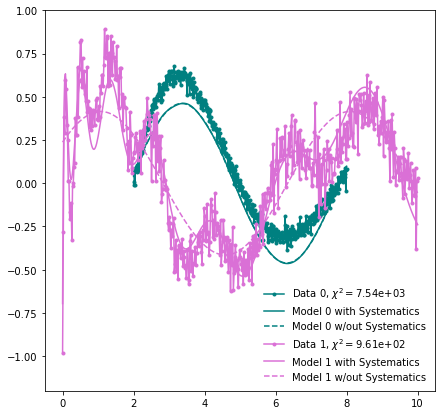

In [29]:
for i,this_consensus in enumerate(consensus_names):
    these_interpreter_cosmologies = interpreter_cosmologies.copy()
    result = run_consensus_compare(this_consensus, experiment_names, interpreter_names, these_interpreter_cosmologies, true_cosmology, experimental_parameters, noise_parameters, consensus_kwargs[i], true_systematics = true_systematics, starting_systematics = starting_systematics)
    break